# Getting Started in Jupyter Notebook

## Import the necessary modules

In [1]:
import logging
import pandas as pd
import numpy as np
from typing import Dict, Any
from pyofw.config import AppType, OFWConfig

## Initiate the logging [Optional but recommended]

In [2]:
logging.basicConfig(
    level=logging.DEBUG,
    # level=logging.INFO,
    format="%(asctime)s.%(msecs)03d %(levelname)s: %(message)s",
    datefmt="%d %H:%M:%S",
)
log = logging.getLogger(__name__)
log.info("Ready to log!")

11 13:39:46.365 INFO: Ready to log!


## Make things ready for Open Flows API

The approach below is using `pyOFW` module which comes with simplified version `OFWConfig` class.

In [3]:
ofw = OFWConfig(
    app_type=AppType.WaterGEMS, # the default is WaterGEMS, this line can be commented
    dlls_dir=OFWConfig.WTRG_INSTALL_DIR # the default is for WaterGEMS, this line can be commented
    )

11 13:39:46.377 DEBUG: Assembly dir is set to: C:\Program Files (x86)\Bentley\WaterGEMS\x64
11 13:39:46.618 DEBUG: Assembly loaded: OpenFlows.Water
11 13:39:46.619 INFO: Assemblies loaded successfully: Count = 1
11 13:39:47.592 DEBUG: Session for AppType.WaterGEMS started
11 13:39:47.592 DEBUG: OFWConfig initialized. Success: True


## Import OpenFlows related modules

It is important to import these modules after loading the `OpenFlows.dll`. The loading of the OpenFlows.dll is taken care in the pyofw package inside `OFWConfig`..

In [4]:
from OpenFlows.Water.Domain import IWaterModel

## Open up the model file

In [5]:
# Path of the model file to be opened
model_filepath = r"C:\Program Files (x86)\Bentley\WaterGEMS\Samples\Example5.wtg"

logging.info("Opening model...")
model: IWaterModel = ofw.open_model(model_filepath)


if model != None:
  logging.info(f"Opened '{model}' model got opened...")

11 13:39:47.611 INFO: Opening model...
11 13:39:47.611 DEBUG: About to open up a model file: C:\Program Files (x86)\Bentley\WaterGEMS\Samples\Example5.wtg
11 13:39:49.620 INFO: Successfully opened up the model. Path: C:\Program Files (x86)\Bentley\WaterGEMS\Samples\Example5.wtg
11 13:39:49.622 INFO: Opened 'Example5.wtg' model got opened...


## Run a Scenario

In [6]:
# display the active scenario
scenario = model.ActiveScenario
logging.info(f"Active scenario = ID: {scenario.Id}, Label: {scenario.Label}")

# display all the scenarios in the model
scenarios_text = [f"ID: {scenario.Id}, Label: {scenario.Label}" for scenario in model.Scenarios.Elements()]
logging.info("List of scenarios in the model:")
logging.info("\n\t".join(scenarios_text))


# check if we have results
has_results = model.ActiveScenario.HasResults
logging.info(f"Active scenario '{model.ActiveScenario.Label}' has results?  {has_results}")

# run the active scenario
logging.info("About to run the simulation")
model.RunActiveScenario()
logging.info("Ran the simulation. ")


# now we should have results
has_results = model.ActiveScenario.HasResults
logging.info(f"Active scenario '{model.ActiveScenario.Label}' has results?  {has_results}")

11 13:39:49.638 INFO: Active scenario = ID: 685, Label: Historical SCADA Simulation
11 13:39:49.644 INFO: List of scenarios in the model:
11 13:39:49.645 INFO: ID: 53, Label: Original Data
	ID: 54, Label: 2002 Calibrated Average Day
	ID: 55, Label: 2002 New Subdivision
	ID: 56, Label: Variable Speed Pumping
	ID: 57, Label: Optimized Calibration
	ID: 58, Label: Submodel
	ID: 59, Label: Automated Fire Flow
	ID: 626, Label: Pump Shut Down Transient Analysis
	ID: 639, Label: Live SCADA Simulation
	ID: 685, Label: Historical SCADA Simulation
11 13:39:49.649 INFO: Active scenario 'Historical SCADA Simulation' has results?  False
11 13:39:49.650 INFO: About to run the simulation
11 13:39:51.550 INFO: Ran the simulation. 
11 13:39:51.572 INFO: Active scenario 'Historical SCADA Simulation' has results?  True


## Prepare data for plotting/charting/graphing

In this seciton, we will be using plotly library to display the charts.
So, these modules might be needed:
1. plotly (`pip install plotly`)
2. `pip install nbformat`

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True) # for offline support

# to display multiple output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [8]:
# Prepare the datetime (x-axis)
times_in_sec = model.ActiveScenario.TimeStepsInSeconds
df = pd.DataFrame()
df["DateTime"] = pd.to_datetime([f"{model.ActiveScenario.TimeStepToDateTime(t)}" for t in times_in_sec])


# prepare the y-axis
# tank levels
tanks = model.Network.Tanks.Elements()
tank_results: Dict[str, Any] = dict()

for tank in tanks:
    tank_results[tank.Label] =tank.Results.Levels()

# pump flows
pumps = model.Network.Pumps.Elements()
pump_results: Dict[str, Any] = dict()

for pump in pumps:
    pump_results[pump.Label] = pump.Results.Flows()

# combine all data into one
df = df.join(pd.DataFrame(tank_results))
df = df.join(pd.DataFrame(pump_results))

df.head()

C:\Users\Akshaya.Niraula\AppData\Local\Temp\ipykernel_66660\3666597561.py:4: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



,DateTime,T-1,PMP-1,PMP-2
0,2007-09-01 00:00:00,30.000005,65.455017,84.823753
1,2007-09-01 00:57:00,31.003163,69.189684,0.000000
2,2007-09-01 01:00:00,31.000428,69.197454,0.000000
3,2007-09-01 02:00:00,30.938404,69.373640,0.000000
4,2007-09-01 03:00:00,30.878817,69.542463,0.000000


## Chart/graph/plot the data in one panel (using secondary axis)

In [9]:
fig = go.Figure()
chart_name = f"Tank Level & Pump Flow - [Scenario = {model.ActiveScenario.Label}]"

def add_line_chart_h(fig, x_values: pd.Series, y_values: pd.Series, name: str, right_y:bool=False):
    y_axis_name = "y2" if right_y else None
    return fig.add_trace(go.Scatter(x=x_values, y=y_values, name=name,yaxis=y_axis_name))

fig = add_line_chart_h(fig, df[df.columns[0]], df[df.columns[1]], df.columns[1])
fig = add_line_chart_h(fig, df[df.columns[0]], df[df.columns[2]], df.columns[2], True)
fig = add_line_chart_h(fig, df[df.columns[0]], df[df.columns[3]], df.columns[3],True)

fig = fig.update_layout(
        title_text=chart_name,
        yaxis=dict(title="Level"),
        yaxis2=dict(overlaying="y", side="right", position=1.0, title="Flows"),
        margin=dict(l=10, r=10, t=50, b=20),
        hovermode='x', # Enable compare data on hover by default
        showlegend=True,
        legend=dict(orientation="h",xanchor="center", x=0.5),
    )

fig.show()

## Chart/graph/plot the data in two panels (sub-plots, just like in WaterGEMS)

In [10]:
fig = go.Figure()
chart_name = f"Tank Level & Pump Flow (WaterGEMS Style) - [Scenario = {model.ActiveScenario.Label}]"

fig = make_subplots(
    rows=2,
    cols=1,
    shared_yaxes=False,
    shared_xaxes=True,
    vertical_spacing=0.0,
)

def add_line_chart_v(fig, x_values: pd.Series, y_values: pd.Series, name: str, bottom_panel:bool=False):
    row = 2 if bottom_panel else 1
    return fig.add_trace(go.Scatter(x=x_values, y=y_values, name=name,),row=row, col=1)

fig = add_line_chart_v(fig, df[df.columns[0]], df[df.columns[1]], df.columns[1])
fig = add_line_chart_v(fig, df[df.columns[0]], df[df.columns[2]], df.columns[2], True)
fig = add_line_chart_v(fig, df[df.columns[0]], df[df.columns[3]], df.columns[3], True)

fig = fig.update_layout(
        title_text=chart_name,
        yaxis=dict(title= f"Level ({model.Units.NetworkUnits.Tank.LevelUnit.ShortLabel})"),
        yaxis2=dict(title=f"Flow  ({model.Units.NetworkUnits.Pump.FlowUnit.ShortLabel})"),
        margin=dict(l=30, r=30, t=50, b=20),
        hovermode='x', # Enable compare data on hover by default
        showlegend=True,
        legend=dict(orientation="h",xanchor="center", x=0.5),
    )

fig.show()

## Data Tables

In [11]:
from pyofw.network_input import NetworkInput
ni = NetworkInput(model)

In [12]:
ni.junction_df.head(2)

,Label,Id,Elevation,IsActive,Zone,ZoneId,ZoneLabel,InitAge,InitConc,InitTrace,Geometry,X,Y
0,J-197,292,149.0,True,Zone : 116 : ResComA,116,ResComA,0.0,0.0,0.0,"(699712.497, 21502.5174)",699712.497,21502.5174
1,J-194,291,151.0,True,Zone : 116 : ResComA,116,ResComA,0.0,0.0,0.0,"(700065.076, 21667.2259)",700065.076,21667.2259


## Draw the Network using nextwokx module

11 13:39:52.715 DEBUG: matplotlib data path: d:\Development\Python\pyofw\.venv\Lib\site-packages\matplotlib\mpl-data
11 13:39:52.721 DEBUG: CONFIGDIR=C:\Users\Akshaya.Niraula\.matplotlib
11 13:39:52.723 DEBUG: interactive is False
11 13:39:52.724 DEBUG: platform is win32
11 13:39:52.781 DEBUG: CACHEDIR=C:\Users\Akshaya.Niraula\.matplotlib
11 13:39:52.784 DEBUG: Using fontManager instance from C:\Users\Akshaya.Niraula\.matplotlib\fontlist-v330.json
11 13:39:52.973 DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
11 13:39:52.974 DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
11 13:39:52.977 DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
11 13:39:52.978 DEBUG: findfont: score(FontEntry(fname='d:\\Development\\Python\\pyofw\\.venv\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', w

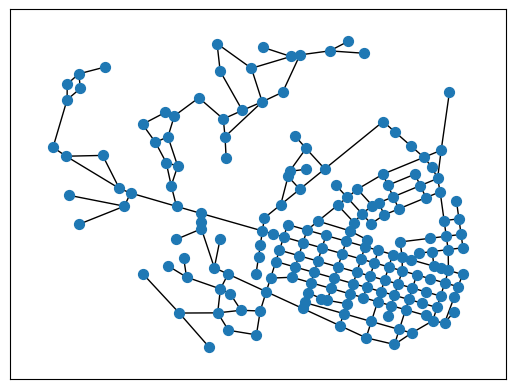

In [13]:
from pyofw.network_input import NetworkInput
import networkx as nx
# Note: matplotlib is also required

ni = NetworkInput(model)

graph = ni.get_networkx_graph(laterals=False)
node_pos = nx.get_node_attributes(graph, "pos")

nx.draw_networkx(graph,pos=node_pos, node_size=50, with_labels=False)

## Close the model

In [14]:
# Disable the comments below to close the model
# if model:
#     model.Close()

## Close the session

If you want to open up the model again, make sure to call the `OFWConfig` as [done above](#Import-OpenFlows-related-modules)

In [15]:
# Disable the comment below to close the session
ofw.end_session()

11 13:39:53.404 DEBUG: About to close the model...
11 13:39:53.450 INFO: Closed the model.
11 13:40:09.905 INFO: Session ended. See you soon.
